# Gendered Reception of Politicians in Online Political Discourse

### Computational Social Sciences

**Authors:** Tudor, Salome, Miguel, Micaela, Mathilde  
**Course:** Computational Social Sciences (2025–2026)

---

## Abstract

Online social media platforms have become central arenas for political debate, shaping public perception of political actors. Previous research suggests that women in politics are subject to different forms of evaluation and criticism than their male counterparts, often involving gendered language and personal attacks.

In this project, we investigate how the online reception of female politicians differs from that of male politicians using computational methods. Relying on publicly available datasets of political discussions on social media, we analyze textual content and interaction structures to identify differences in sentiment, toxicity, thematic focus, and network dynamics.

By combining natural language processing techniques with graph-based analysis, this study aims to contribute to a better understanding of gender bias in online political discourse while critically reflecting on the methodological and ethical limitations of computational approaches.


1. Invisible Women in Digital Diplomacy: A Multidimensional Framework for Online Gender Bias Against Women Ambassadors Worldwide [https://arxiv.org/abs/2311.17627?utm]
2. Gender Differences in Abuse: The Case of Dutch Politicians on Twitter [https://arxiv.org/abs/2306.10769?utm]
3. Gender stereotypes in politics: Insights from social media data [https://www.sciencedirect.com/science/article/abs/pii/S016517652500240X?utm]
4. Polarization and hate speech with gender bias associated with politics: analysis of interactions on Twitter [https://www.redalyc.org/journal/5894/589475507003/?utm]

## 1. Introduction

Social media platforms play a crucial role in contemporary political communication, enabling direct interaction between political figures and the public. While these platforms can foster political engagement, they also expose public figures to large volumes of unmoderated commentary, including harassment and hate speech.

Gender bias in political communication has been documented in traditional media, where women are often evaluated based on personal attributes rather than political positions. Online platforms introduce additional dynamics such as anonymity, virality, and network effects, which may amplify these biases.

This project focuses on the reception of politicians on social media, examining whether female politicians are discussed, criticized, or targeted differently compared to male politicians. Using computational tools, we aim to move beyond anecdotal evidence and provide a systematic analysis of large-scale online discourse.

## 2. Research Question and Hypotheses

### Research Question

How does the online reception of female politicians differ from that of male politicians in political discussions on social media?

### Sub-questions

- Are comments directed at female politicians more negative or toxic than those directed at male politicians?
- Do the dominant topics differ between discussions about female and male politicians?
- Are gendered themes (e.g. appearance, legitimacy, personal life) more prevalent in comments about women?
- Do negative comments exhibit different interaction patterns or levels of coordination depending on the politician’s gender?

### Hypotheses

- **H1:** Comments addressing female politicians exhibit higher levels of toxicity than those addressing male politicians.
- **H2:** Topic modeling reveals gender-specific themes, with comments about women more frequently referencing appearance or personal attributes.
- **H3:** Toxic comments directed at female politicians form denser or more coordinated interaction clusters.


## 3. Methodological Overview

To address the research questions, we adopt a computational approach combining text analysis and network analysis.

### Methods

- **Natural Language Processing (NLP):**
  - Text preprocessing
  - Sentiment and toxicity classification using pre-trained models
  - Topic modeling to uncover dominant themes in discussions

- **Graph Analysis:**
  - Construction of reply or interaction networks
  - Analysis of centrality, clustering, and coordination patterns

### Computational Social Science Perspective

While computational methods enable large-scale analysis, they are not neutral. Automated classifiers may encode social biases, and network structures may reflect platform-specific affordances. These limitations are explicitly discussed in the analysis.


In [ ]:
import sys
sys.executable

# INSTALL ALL OF THIS LIBRARIES BEFORE RUNNING THE CODE
# %pip install pandas numpy matplotlib seaborn nltk scikit-learn networkx transformers torch wordcloud textblob kagglehub

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import sqlite3
import os


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

# Graphs
import networkx as nx

# Utils
from collections import Counter

# Kagglehub for dataset download
import kagglehub

# install torch and after, transformers
import torch
from transformers import pipeline

print("Environment ready")


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

## 4. Data Sources

Due to access restrictions and recent policy changes affecting the Twitter/X API, this project relies on **publicly available datasets** commonly used in computational social science research.

The datasets consist of social media posts and replies related to political actors during specific political events. Each observation includes textual content and interaction metadata, enabling both linguistic and network-based analyses.

Using open datasets ensures reproducibility, transparency, and ethical compliance, while still allowing us to study real-world political discourse at scale.

In [ ]:
# Download datasets

path_2017 = kagglehub.dataset_download("jeanmidev/french-presidential-election")
path_2022 = kagglehub.dataset_download("jeanmidev/french-presidential-online-listener")

path_2022 = os.path.join(path_2022, "2022/twitter")

print("Path to dataset 2017 files:", path_2017)
print("Path to dataset 2022 files:", path_2022)

Import the 2017 databases into a dictionary of dataframes

In [ ]:
path_googletrends = os.path.join(path_2017, "database_googletrends.sqlite")
if (os.path.exists(path_googletrends)):
    os.remove(path_googletrends)

dfs_dict_2017 = {}
mention_2017=['"mention_Macron"', '"mention_Le PEN"']

for m in mention_2017:
    for file in os.listdir(path_2017):
        # print("File in dataset:", file)

        file_path = os.path.join(path_2017, file)
        # print("Loading file:", file_path)

        connection = sqlite3.connect(file_path)
        # print("Reading the database")

        sql_query = f"SELECT text, day, hour FROM data WHERE lang='en' AND "+m+"=1;"
        if m not in dfs_dict_2017:
            dfs_dict_2017[m] = []
        dfs_dict_2017[m].append(pd.read_sql_query(sql_query, connection))

        connection.close()

# concat tweets of all database on one list
for m in mention_2017:
    dfs_dict_2017[m] = pd.concat(dfs_dict_2017[m], ignore_index=True)

print(dfs_dict_2017)
print("Finalized loading 2017 databases into dataframes dictionary")

Import 2022 databases into a dictionary

In [ ]:
dfs_dict_2022 = {}
mention_2022 = ['macron', 'pen']

for file in os.listdir(path_2022):
    print("File in dataset:", file)
    file_path = os.path.join(path_2022, file)

    # Read the CSV file
    df_temp = pd.read_csv(file_path, low_memory=False)

    for m in mention_2022:
        # Filter rows containing "macron" or "pen" (case-insensitive)
        # This checks all string columns for the keywords
        mask = df_temp.astype(str).apply(
            lambda x: x.str.contains(m, case=False, na=False)
        ).any(axis=1)

        if m not in dfs_dict_2022:
            dfs_dict_2022[m] = []

        dfs_dict_2022[m].append(df_temp[mask])


print(dfs_dict_2022)
for m in mention_2022:
    dfs_dict_2022[m] = pd.concat(dfs_dict_2022[m], ignore_index=True)

print(dfs_dict_2022)
print("Finalized loading 2022 csv into dataframes dictionary")

In [ ]:
# For testing, we create an example dataset
data = {
    "comment_id": [1,2,3,4,5],
    "text": [
        "I really support Marine Le Pen, she's amazing!",
        "Jordan Bardella's policy ideas are terrible",
        "Marine Le Pen is strong but looks unfriendly",
        "Bardella seems competent but inexperienced",
        "Le Pen is awful, can't stand her"
    ],
    "target_politician": ["Marine Le Pen","Jordan Bardella","Marine Le Pen","Jordan Bardella","Marine Le Pen"],
    "gender": ["F","M","F","M","F"],
    "timestamp": ["2026-01-01 12:00","2026-01-01 12:05","2026-01-01 12:10","2026-01-01 12:15","2026-01-01 12:20"],  # Keep as strings
    "reply_to": [None, 1, None, 2, None],
}

for m in mention_2017:
    # Get the corresponding dataframe from dfs_dict
    df_mention = dfs_dict_2017[m]

    for idx, row in df_mention.iterrows():
        data["comment_id"].append(len(data["comment_id"])+1)
        data["text"].append(row["text"])  # Get text from dfs_dict

        if m == '"mention_Le PEN"':
            data["target_politician"].append("Marine Le Pen")
            data["gender"].append("F")
        else:
            data["target_politician"].append("Emmanuel Macron")
            data["gender"].append("M")

        data["reply_to"].append(None)

        # Create timestamp from day and hour
        timestamp_str = f"{row['day']} {row['hour']}:00:00"
        data["timestamp"].append(timestamp_str)

for m in mention_2022:
    df_mention = dfs_dict_2022[m]

    for idx, row in df_mention.iterrows():
        # Skip rows where 'text' is not a string
        if isinstance(row['text'], str):
            data["comment_id"].append(len(data["comment_id"])+1)
            data["text"].append(row["text"])  # Get text from dfs_dict

            if m == 'pen':
                data["target_politician"].append("Marine Le Pen")
                data["gender"].append("F")
            else:
                data["target_politician"].append("Emmanuel Macron")
                data["gender"].append("M")

            data["reply_to"].append(None)
            # Ensure pure string before conversion
            data["timestamp"].append(str(row['created_date']))

# Convert timestamps with explicit format, otherwise it will crash
converted_ts = pd.to_datetime(data["timestamp"], errors='coerce', format="%Y-%m-%d %H:%M:%S")

df = pd.DataFrame(data)
df["timestamp"] = converted_ts
df.head()

Save the df to a csv file

In [ ]:
df.to_csv("le_pen_macron_twitter_2017_2022.csv", index=False)

Import the csv to pandas dataframe

In [ ]:
df = pd.read_csv("le_pen_macron_twitter_2017_2022.csv")

## 5. Data Cleaning and Preprocessing

Before running any NLP or graph analyses, we perform basic preprocessing to unify all the dataset:

- Convert text to lowercase
- Remove punctuation and special characters
- Tokenize text
- Remove stopwords
- Optional: lemmatization/stemming

In [ ]:
## observation: to start it is not needed but after
## i want to add a part that considers that some comments will refer
## only to the last name of the politician, and not the complete name
# code included in the annexe for the moment
import nlp

stop_words = nlp.Defaults.stop_words


# Basic text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s']", "", text)  # allows letters, spaces and '
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

stop_words = set(stopwords.words('english'))  # adjust if it's French


def simple_tokenize(text):
    return text.split()

def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()  # simple tokenize
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)
df[["text","clean_text"]]


Version for Mac OS -> nlp doesn't work

In [ ]:
import re
import spacy

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Get stopwords
stop_words = nlp.Defaults.stop_words

# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s']", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Example usage
df["clean_text"] = df["text"].apply(preprocess_text)


## 6. Exploratory Data Analysis (EDA)

Before performing NLP or network analyses, we check:

- Number of comments per politician
- Number of comments per gender
- Distribution of comment length
- Simple word frequency counts to see dominant terms

This helps us understand the dataset and spot potential biases.


In [ ]:
# Comments per politician
print("Comments per politician:")
print(df.groupby("target_politician").size())

# Comments per gender
print("\nComments per gender:")
print(df.groupby("gender").size())

# Text length
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
print("\nComment lengths:")
print(df[["target_politician","text_length"]])

# Most frequent words (first look)
from collections import Counter

all_words = " ".join(df["clean_text"]).split()
word_freq = Counter(all_words)
print("\nTop words:", word_freq.most_common(10))

- Graph the number of comments per election period

/tmp/ipykernel_474228/74179719.py:14: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


target_politician  Emmanuel Macron  Marine Le Pen
timestamp                                        
2021-10-10                      85             17
2021-10-17                     559            140
2021-10-24                     477            177
2021-10-31                    1030            293
2021-11-07                    2968           1030
2021-11-14                  302916          75214
2021-11-21                  225444          67318
2021-11-28                  195367          75451
2021-12-05                  246153          93743
2021-12-12                  329274         108820
2021-12-19                  375696          94642
2021-12-26                  194197          68852
2022-01-02                  306839          58643
2022-01-09                  815869         125344
2022-01-16                  423997         136326
2022-01-23                  469212         161623
2022-01-30                  343987         164703
2022-02-06                  461834         224397


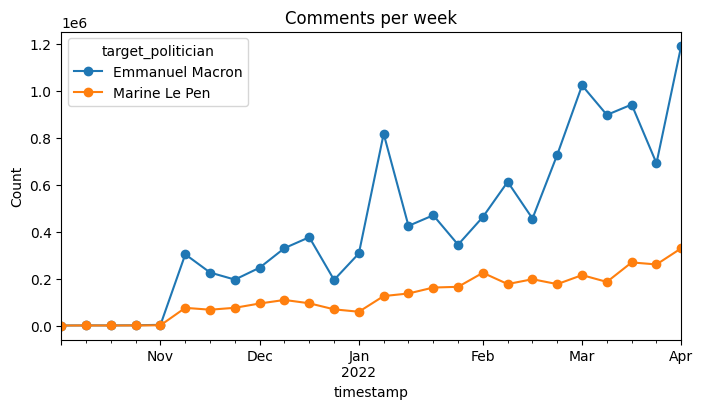

target_politician  Emmanuel Macron  Marine Le Pen
timestamp                                        
2017-01-15                     1.0            0.0
2017-01-22                     1.0            0.0
2017-01-29                     4.0            3.0
2017-02-05                     5.0            5.0
2017-02-12                     4.0            4.0
2017-02-19                    63.0            2.0
2017-02-26                     5.0           12.0
2017-03-05                     6.0            4.0
2017-03-12                     6.0            2.0
2017-03-19                    15.0            3.0
2017-03-26                    24.0            9.0
2017-04-02                    16.0            3.0
2017-04-09                  1002.0         6853.0
2017-04-16                 11435.0        53898.0
2017-04-23                 75739.0       221387.0
2017-04-30                171824.0       195748.0
2017-05-07                466480.0       254594.0
2017-05-14                276443.0        91696.0


/tmp/ipykernel_474228/74179719.py:38: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


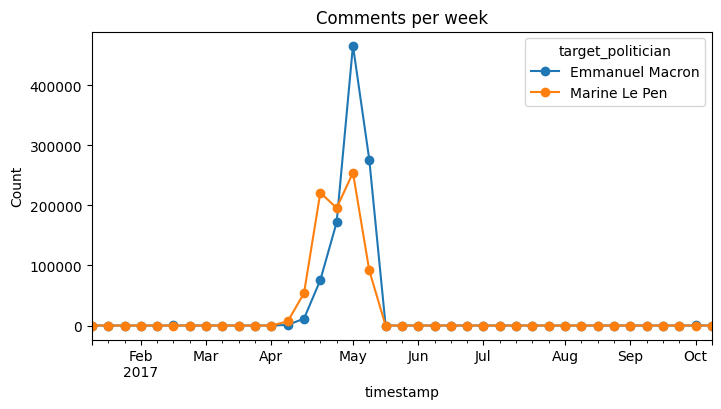

In [ ]:
# See the total negative comments Macron vs Le Penn over a time period.
import matplotlib.pyplot as plt

# Set the period you want (start/end). Adjust as needed.
start, end = "2021-10-10", "2023-12-10"
mask = df["timestamp"].between(start, end)

# Counts per week per politician
weekly_counts = (
    df.loc[mask]
      .set_index("timestamp")
      .groupby("target_politician")
      .resample("W")
      .size()
      .unstack(0)
      .fillna(0)
)

print(weekly_counts)

# Quick plot
weekly_counts.plot(figsize=(8, 4), marker="o")
plt.title("Comments per week")
plt.ylabel("Count")
plt.show()


# Set the period you want (start/end). Adjust as needed.
start, end = "2017-01-10", "2017-10-10"
mask = df["timestamp"].between(start, end)

# Counts per week per politician
weekly_counts = (
    df.loc[mask]
      .set_index("timestamp")
      .groupby("target_politician")
      .resample("W")
      .size()
      .unstack(0)
      .fillna(0)
)

print(weekly_counts)

# Quick plot
weekly_counts.plot(figsize=(8, 4), marker="o")
plt.title("Comments per week")
plt.ylabel("Count")
plt.show()

In [ ]:

# see pythorch version
print("PyThorch version:", torch.__version__)

# take into consideration macbooks
device = 0
if not (torch.cuda.is_available()):
    device = -1
    import os
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

classifier = pipeline("sentiment-analysis",
                      model="distilbert-base-uncased-finetuned-sst-2-english",
                      device=device)

print(classifier("Me encanta aprender data science!"))


In [ ]:


# # We create a sentiment analysis pipeline
# # If you want more specific toxicity detection, there are models like "unitary/toxic-bert" on HuggingFace
# sentiment_model = pipeline("sentiment-analysis")

# # Apply to the dataframe (only a few examples)
# df["sentiment"] = df["clean_text"].apply(lambda x: sentiment_model(x)[0]["label"])
# df["sentiment_score"] = df["clean_text"].apply(lambda x: sentiment_model(x)[0]["score"])

# df[["text","clean_text","sentiment","sentiment_score"]]

## Optimize the run by processing in batch mode
# Create the pipeline
sentiment_model = pipeline("sentiment-analysis")

# Run the model in batch mode for all texts
results = sentiment_model(list(df["clean_text"]))

# Extract labels and scores
df["sentiment"] = [r["label"] for r in results]
df["sentiment_score"] = [r["score"] for r in results]

df[["text", "clean_text", "sentiment", "sentiment_score"]]

In [ ]:
from collections import Counter

# todas las palabras
all_words = " ".join(df["clean_text"]).split()
word_freq = Counter(all_words)

# top 10
top_words = word_freq.most_common(10)
print("Top 10 words:", top_words)

# gráfico
words, counts = zip(*top_words)
plt.figure(figsize=(8,4))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 10 most frequent words")
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(texts):
    text = " ".join(texts)
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
plot_wordcloud(df["clean_text"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#représentation TF-IDF afin de pondérer les termes en fonction de leur importance relative dans chaque tweet et de leur rareté dans le data set -> permet une comparaison quantitative entre tweets et groupes de tweets

def compute_tfidf(texts, max_features=1000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

positive = df[df["sentiment"] == "POSITIVE"]["clean_text"] # ou avant/après une date -> utile pour les evenements par exemple
negative = df[df["sentiment"] == "NEGATIVE"]["clean_text"]
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])

feature_names = np.array(vectorizer.get_feature_names_out())

pos_idx = positive.index
neg_idx = negative.index

tfidf_pos = X[pos_idx].mean(axis=0).A1
tfidf_neg = X[neg_idx].mean(axis=0).A1

delta = tfidf_pos - tfidf_neg

top_pos = feature_names[np.argsort(delta)[-10:]]
top_neg = feature_names[np.argsort(delta)[:10]]

import matplotlib.pyplot as plt

words = np.concatenate([top_neg, top_pos])
scores = np.concatenate([
    delta[np.argsort(delta)[:10]],
    delta[np.argsort(delta)[-10:]]
])

plt.figure(figsize=(10,5))
plt.barh(words, scores)
plt.axvline(0)
plt.title("Mots discriminants (TF-IDF)")
plt.xlabel("TF-IDF positif  ←  →  négatif")
plt.show()

In [ ]:
def plot_tweets_mar_may_2017_continuous(df, date_col):
    # Conversion en datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Filtrer uniquement l'année 2017
    df_2017 = df[df[date_col].dt.year == 2017].copy()

    # Filtrer entre mars et mai
    df_period = df_2017[(df_2017[date_col].dt.month >= 3) &
                        (df_2017[date_col].dt.month <= 5)]

    # Créer une colonne 'day' pour le regroupement
    df_period['day'] = df_period[date_col].dt.date

    # Compter le nombre de tweets par jour
    counts = df_period.groupby('day').size()

    # Créer un index de tous les jours entre mars et mai
    all_days = pd.date_range(start='2017-03-01', end='2017-05-31', freq='D')

    # Réindexer pour inclure les jours sans tweet
    counts = counts.reindex(all_days.date, fill_value=0)

    # Tracer la courbe
    plt.figure(figsize=(14,5))
    plt.plot(counts.index, counts.values, marker='o')
    plt.xlabel("Jour")
    plt.ylabel("Nombre de tweets")
    plt.title("Nombre de tweets par jour (mars → mai 2017)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()




df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp")  # Assure un ordre chronologique

plot_tweets_mar_may_2017(df, "timestamp")

In [ ]:
from textblob import TextBlob

def sentiment_score(text):
    return TextBlob(text).sentiment.polarity
df["sentiment"] = df["clean_text"].apply(sentiment_score)
df["sentiment"].hist(bins=30)
plt.title("Distribution des sentiments")
plt.show()


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df["vader_sentiment"] = df["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
df["vader_sentiment"].hist(bins=30)
plt.title("Distribution des scores VADER")
plt.show()

# Vader is specifically designed for social media text and provides a compound score ranging from -1 (most negative) to +1 (most positive).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# X = liste de tweets, y = labels (0=non toxique, 1=toxique)
X = df["clean_text"]
y = (df["sentiment"] == "NEGATIVE").astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_vec, y_train)
score = model.score(X_test_vec, y_test)
print(f"Précision : {score}")


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import re

# Initialiser VADER pour l'analyse de toxicité
analyzer = SentimentIntensityAnalyzer()

# Listes de pronoms et mots genrés
pronoms_feminin = ["elle", "elles", "la", "l'", "une", "celle", "celles", "madame", "mme", "femme", "dame", "mère", "sœur"]
pronoms_masculin = ["il", "ils", "le", "l'", "un", "celui", "ceux", "monsieur", "mr", "homme", "garçon", "père", "frère"]
pronoms_pluriel = ["ils", "elles", "eux", "les", "leurs", "mesdames", "messieurs"]

# Fonction pour détecter le genre
def detecter_genre(texte):
    texte = texte.lower()
    count_feminin = sum(len(re.findall(rf"\b{re.escape(pronom)}\b", texte)) for pronom in pronoms_feminin)
    count_masculin = sum(len(re.findall(rf"\b{re.escape(pronom)}\b", texte)) for pronom in pronoms_masculin)
    count_pluriel = sum(len(re.findall(rf"\b{re.escape(pronom)}\b", texte)) for pronom in pronoms_pluriel)

    if count_feminin > count_masculin and count_feminin > count_pluriel:
        return "féminin"
    elif count_masculin > count_feminin and count_masculin > count_pluriel:
        return "masculin"
    elif count_pluriel > 0:
        return "pluriel"
    else:
        return "neutre"

# Fonction pour analyser la toxicité avec VADER
def analyser_toxicite(texte):
    sentiment = analyzer.polarity_scores(texte)
    return sentiment["compound"]  # Score entre -1 (toxique) et +1 (positif)

# Appliquer les fonctions à chaque tweet
df["genre"] = df["clean_text"].apply(detecter_genre)
df["toxicite"] = df["clean_text"].apply(analyser_toxicite)

# Classer la toxicité (ex : toxique si score < -0.3)
df["est_toxique"] = df["toxicite"] < -0.3

# Sauvegarder les résultats
df.to_csv("tweets_analyses.csv", index=False)

# Afficher un aperçu
print(df.head())


In [ ]:
## This code is not working correctly right now, needs more adjustments
## maybe it would be useful to replace politician names with ids as said before
# look in the annexe

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizar textos
vectorizer = CountVectorizer(max_df=0.9, min_df=1, stop_words='english')
dtm = vectorizer.fit_transform(df["clean_text"])

# LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(dtm)

# mostrar temas
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", [feature_names[i] for i in topic.argsort()[-no_top_words:]])

display_topics(lda, vectorizer.get_feature_names_out(), 5)

In [ ]:
## first test with a real database
## tried to install kaggle package and download dataset from kaggle
## didnt work but internet says that it is possible because its an old competition
## ended up downloading it manually

'''
# instalar paquete kaggle
%pip install kaggle

# si no pusiste kaggle.json en la carpeta .kaggle, podés crearlo desde el notebook
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

from kaggle.api.kaggle_api_extended import KaggleApi

# crear carpeta data si no existe
os.makedirs("data", exist_ok=True)

# iniciar API
api = KaggleApi()
api.authenticate()

# descargar dataset completo (zip)
api.competition_download_files(
    "jigsaw-toxic-comment-classification-challenge",
    path="data"
)

# el archivo se llama algo así: jigsaw-toxic-comment-classification-challenge.zip

# descargamos el dataset completo (zip)
kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p ./data

# descomprimir
import zipfile
with zipfile.ZipFile("./data/jigsaw-toxic-comment-classification-challenge.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

df_real = pd.read_csv("./data/train.csv")
df_real.head()

'''

import zipfile
import os
import pandas as pd

data_folder = "data"

# lista todos los archivos zip en data
zip_files = [f for f in os.listdir(data_folder) if f.endswith(".zip")]

# descomprimir cada uno
for z in zip_files:
    with zipfile.ZipFile(os.path.join(data_folder, z), "r") as zip_ref:
        zip_ref.extractall(data_folder)


In [ ]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()


In [ ]:
# Basic Exploration

# load dataset
train = pd.read_csv("data/train.csv")

# columnas de etiquetas
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# mostrar primeras filas
print(train.head())

# contar y mostrar distribución de cada etiqueta
label_counts = {}
for col in labels:
    counts = train[col].value_counts()
    label_counts[col] = counts
    print(f"{col}:\n{counts}\n")

# convertir a dataframe para graficar
df_counts = pd.DataFrame({col: train[col].value_counts() for col in labels})
df_counts = df_counts.fillna(0).astype(int)  # asegurarse de que no haya NaN
df_counts = df_counts.T  # para que las etiquetas estén en filas
df_counts.columns = ['No', 'Yes']  # 0 = No, 1 = Sí

# gráfico de barras apiladas
df_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['skyblue', 'salmon'])
plt.title("Distribution of labels in the training dataset")
plt.ylabel("Number of comments")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.legend(title='Toxic', loc='upper right')
plt.show()


In [ ]:
# to start we do binary classification: toxic vs non-toxic

X = train["comment_text"]
y = train["toxic"]  # 1 = tóxico, 0 = no tóxico


In [ ]:
# basic text preprocessing

import re

def clean_text(text):
    # pasar a minúsculas
    text = text.lower()
    # quitar URLs
    text = re.sub(r"http\S+", "", text)
    # quitar caracteres especiales (excepto letras y números)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

X_clean = X.apply(clean_text)


In [ ]:
# Convert text to numbers (TF-IDF)
# this is NLP, I found it online
# i dont know how it works clearly, does anyone want to work on this together?

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X_clean)

In [ ]:
# train and evaluate a simple model
# these are different metrics used in machine learning
# i saw them in a past course, if anyone wants me to help understand please let me know

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# predicciones
y_pred = model.predict(X_val)

# métricas
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


In [ ]:
# limpiar y vectorizar test
X_test_clean = test["comment_text"].apply(clean_text)
X_test_vec = vectorizer.transform(X_test_clean)

# predicciones en test
test_pred = model.predict(X_test_vec)

# crear DataFrame para inspección
results_test = pd.DataFrame({
    "comment": test["comment_text"],
    "pred": test_pred
})

# agregar columna 'pred_label' para mayor claridad
results_test["pred_label"] = results_test["pred"].map({0: "no_toxic", 1: "toxic"})

# mostrar primeras 10 filas con predicción
print(results_test.head(10))


# ANEXE

In [ ]:
# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s']", "", text)  # letters, spaces, '
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

stop_words = set(stopwords.words('english'))  # adjust if it's French

# Diccionario para unificar nombres de políticos
# clave: posible forma en el texto, valor: nombre único
politician_map = {
    'marine le pen': 'marine_le_pen',
    'le pen': 'marine_le_pen',
    'pen': 'marine_le_pen',

    'emmanuel macron': 'emmanuel_macron',
    'macron': 'emmanuel_macron',

    # agregá más políticos si hace falta
}

def replace_politicians(text):
    for key, value in politician_map.items():
        # reemplaza coincidencias exactas de la cadena
        # agregamos espacios delante y detrás para no confundir palabras
        pattern = r'\b' + re.escape(key) + r'\b'
        text = re.sub(pattern, value, text)
    return text

def simple_tokenize(text):
    return text.split()

def preprocess_text(text):
    text = clean_text(text)
    text = replace_politicians(text)  # primero normalizamos nombres
    tokens = text.split()  # simple tokenize
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# aplicar al dataframe
df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text"]]
